<a href="https://colab.research.google.com/github/Raspberry025/Genetic_Algorithm/blob/main/DAML_Group_Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Smart Grid Energy Optimization Using Genetic Algorithm and Greedy Approach**

Import Required Libraries

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import multiprocessing as mp
import time
import psutil
import random

# For inline plots
%matplotlib inline

# Set seed for reproducibility
random.seed(42)
np.random.seed(42)

Load Dataset

In [ ]:
# Load datasets
nodes_df = pd.read_csv("/content/drive/MyDrive/nodes_dataset.csv")        # 50 nodes with hourly demand
sources_df = pd.read_csv("/content/drive/MyDrive/sources_dataset.csv")    # 5 sources with hourly capacity
distance_df = pd.read_csv("/content/drive/MyDrive/distance_matrix.csv", index_col=0)  # 50 x 5 matrix

# Confirm shape and sample
print("Nodes Dataset:", nodes_df.shape)
print("Sources Dataset:", sources_df.shape)
print("Distance Matrix:", distance_df.shape)

# Display few rows
display(nodes_df.head())
display(sources_df.head())
display(distance_df.head())

Nodes Dataset: (50, 27)
Sources Dataset: (5, 29)
Distance Matrix: (50, 5)


,NodeID,Type,Priority,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,...,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,Hour_24
0,N001,Industrial,Low,10.69,6.47,10.65,9.23,8.65,11.22,12.06,...,7.79,7.61,11.63,12.71,9.86,12.01,10.72,8.71,10.72,13.08
1,N002,Industrial,Medium,11.58,8.18,12.81,7.20,11.17,14.38,8.02,...,8.16,13.10,8.43,9.36,11.63,7.54,10.45,12.61,6.79,10.37
2,N003,Residential,Low,2.13,2.39,1.38,1.34,2.26,2.15,2.13,...,1.40,2.33,1.51,2.39,2.58,1.59,2.48,2.21,2.41,2.95
3,N004,Residential,Medium,1.61,1.88,1.76,2.04,3.16,1.07,2.34,...,1.63,2.11,2.02,1.67,3.07,2.32,0.99,2.09,1.67,2.43
4,N005,Industrial,Low,8.35,9.36,10.83,8.87,8.36,10.49,10.49,...,10.62,12.95,11.72,9.68,9.96,7.99,9.96,9.42,10.65,8.35


,SourceID,Type,MaxCapacity,CostPerUnit,LossFactor,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,...,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,Hour_24
0,S01,Hydro,569.06,0.098,0.019,40.00,40.00,40.00,40.00,40.00,...,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00
1,S02,Bio,905.97,0.126,0.040,20.42,20.82,24.30,26.54,22.38,...,41.22,36.54,24.09,24.47,29.98,33.52,16.81,16.07,21.89,27.91
2,S03,Thermal,709.48,0.137,0.036,50.00,50.00,50.00,50.00,50.00,...,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00
3,S04,Bio,891.58,0.102,0.017,23.00,26.35,24.78,25.91,21.65,...,20.15,23.01,31.19,26.90,20.16,23.45,21.93,21.45,29.89,18.14
4,S05,Thermal,681.25,0.122,0.038,50.00,50.00,50.00,50.00,50.00,...,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00


,S01,S02,S03,S04,S05
NodeID,,,,,
N001,1,49,25,10,16
N002,16,8,29,39,28
N003,6,16,20,16,7
N004,41,14,43,26,26
N005,14,7,33,26,45


Exploratory Data Analysis (EDA)

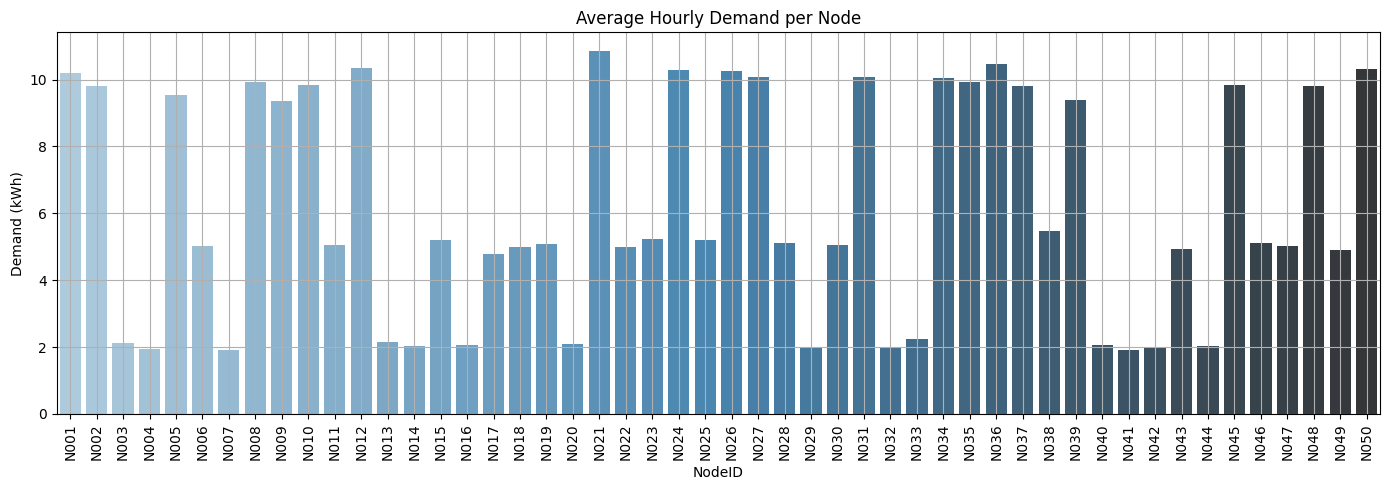

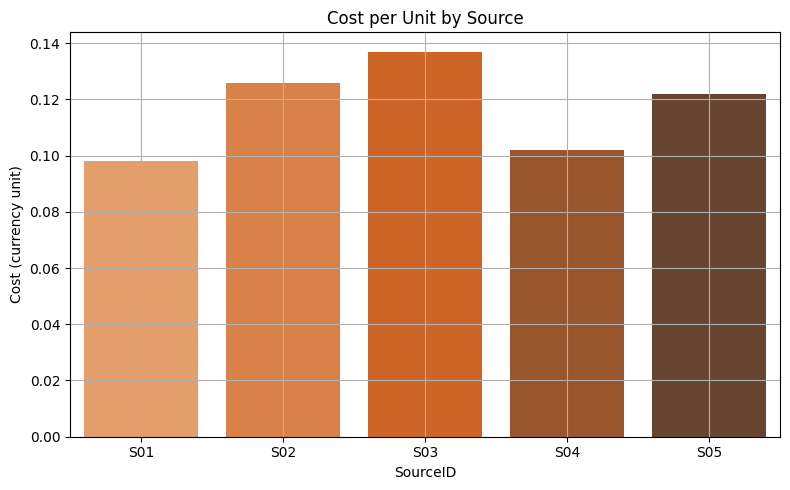

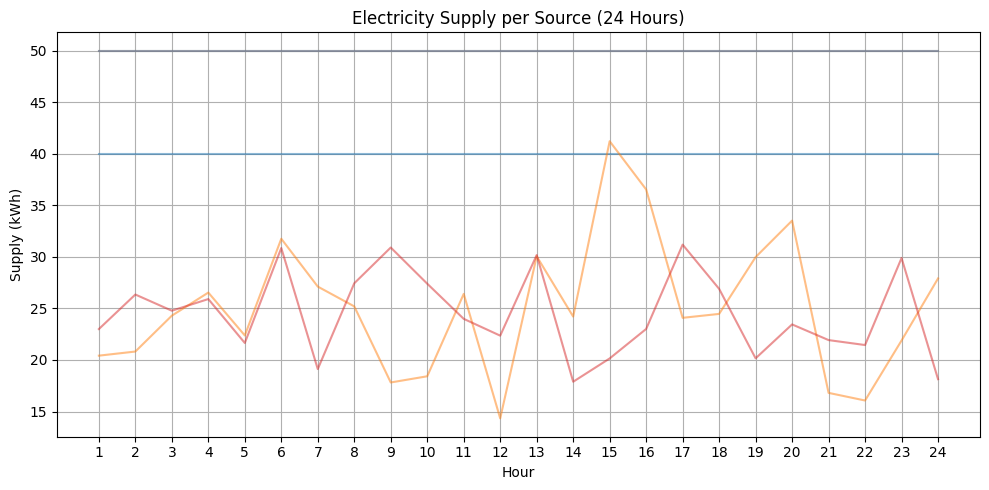

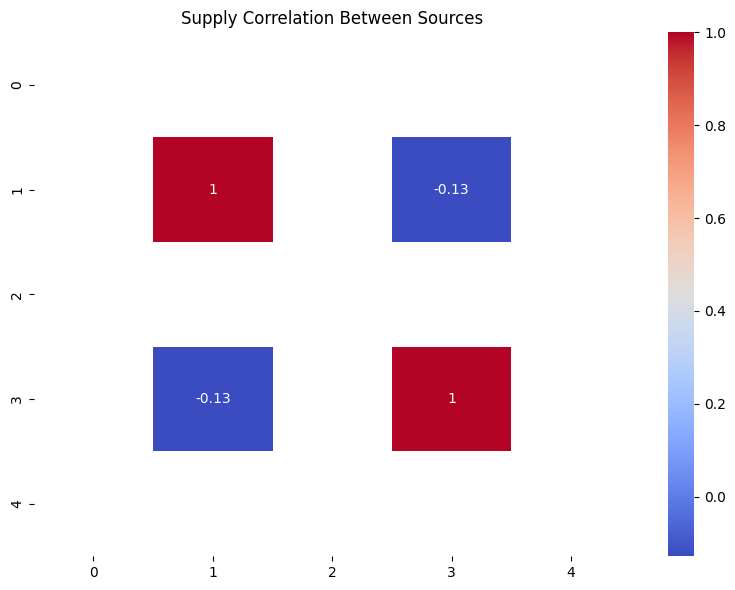

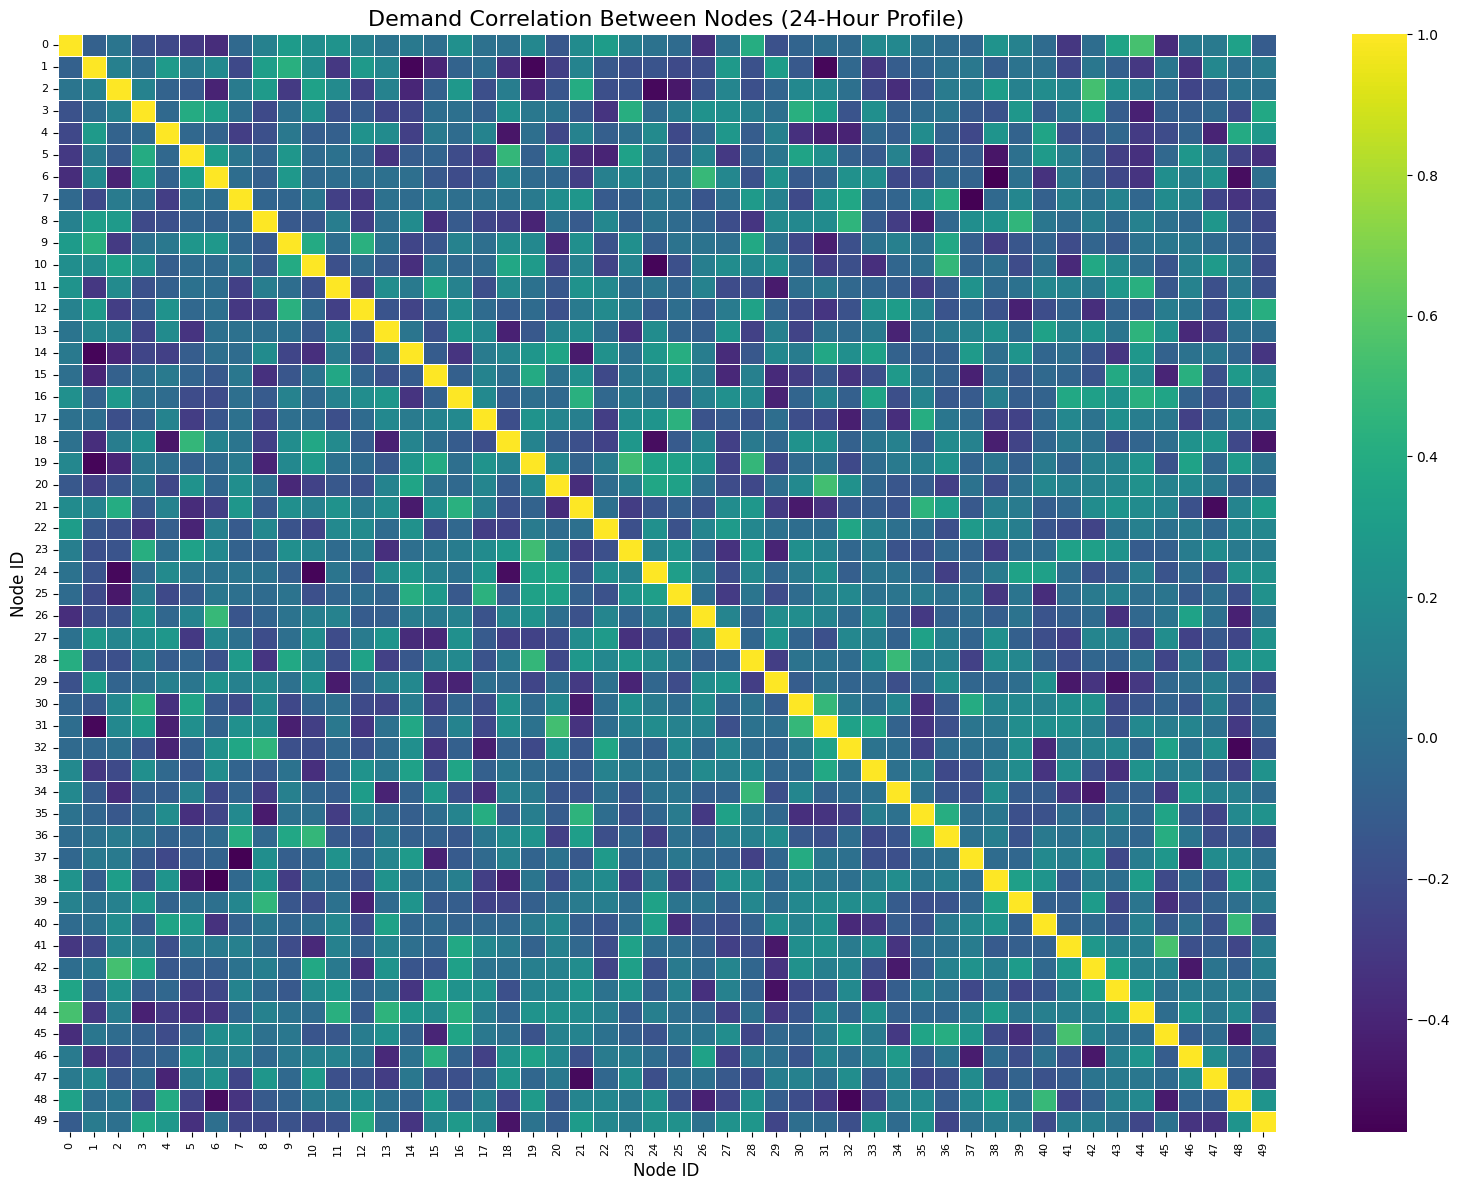

In [ ]:
# 1. Barplot: Average Hourly Demand per Node
nodes_df['AvgDemand'] = nodes_df.loc[:, 'Hour_1':'Hour_24'].mean(axis=1)

plt.figure(figsize=(14, 5))
sns.barplot(data=nodes_df, x='NodeID', y='AvgDemand', hue='NodeID', palette='Blues_d', legend=False)
plt.title("Average Hourly Demand per Node")
plt.xticks(rotation=90)
plt.ylabel("Demand (kWh)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Barplot: Cost per Unit by Source
plt.figure(figsize=(8, 5))
sns.barplot(data=sources_df, x='SourceID', y='CostPerUnit', hue='SourceID', palette='Oranges_d', legend=False)
plt.title("Cost per Unit by Source")
plt.ylabel("Cost (currency unit)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Line Plot: Electricity Supply per Source (24 Hours)
supply_df = sources_df.loc[:, 'Hour_1':'Hour_24']
demand_df = nodes_df.loc[:, 'Hour_1':'Hour_24']
hours = list(range(1, 25))

plt.figure(figsize=(10, 5))
plt.plot(hours, supply_df.T, alpha=0.5)
plt.title('Electricity Supply per Source (24 Hours)')
plt.xlabel('Hour')
plt.ylabel('Supply (kWh)')
plt.xticks(hours)
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Heatmap: Correlation Between Supply Sources
plt.figure(figsize=(8, 6))
sns.heatmap(supply_df.T.corr(), cmap='coolwarm', annot=True)
plt.title("Supply Correlation Between Sources")
plt.tight_layout()
plt.show()

# 5. Correlation Heatmaps
demand_corr = demand_df.T.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(demand_corr, cmap='viridis', annot=False, linewidths=0.5)

plt.title("Demand Correlation Between Nodes (24-Hour Profile)", fontsize=16)
plt.xlabel("Node ID", fontsize=12)
plt.ylabel("Node ID", fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

Problem Setup and Preprocessing

In [ ]:
# Dimensions
num_nodes = nodes_df.shape[0]
num_sources = sources_df.shape[0]
hours = 24

# Demand matrix: shape = [nodes, hours]
demand_matrix = nodes_df.loc[:, 'Hour_1':'Hour_24'].values

# Supply matrix: shape = [sources, hours]
supply_matrix = sources_df.loc[:, 'Hour_1':'Hour_24'].values

# Cost, loss factor, and max daily capacity per source
cost_per_source = sources_df['CostPerUnit'].values              # [sources]
loss_factor_per_source = sources_df['LossFactor'].values        # [sources]
max_daily_capacity = sources_df['MaxCapacity'].values           # [sources]

# Distance matrix: shape = [nodes, sources]
distance_matrix = distance_df[sources_df['SourceID']].values

Chromosome Encoding and Decoding

In [ ]:
# Each chromosome is a flat vector of length: sources * nodes * hours
def generate_random_chromosome():
    return np.random.uniform(0, 30, size=num_sources * num_nodes * hours)

def decode_chromosome(chromosome):
    return chromosome.reshape((num_sources, num_nodes, hours))  # 3D matrix

Fitness Function with All Constraints

In [ ]:
# Fitness Function: Lower score = better
def fitness_function(chromosome):
    allocation = decode_chromosome(chromosome)  # shape: [sources, nodes, hours]
    total_cost = 0
    total_loss = 0
    penalty = 0

    source_hourly_sum = np.zeros((num_sources, hours))  # To track each source usage

    for h in range(hours):
        for n in range(num_nodes):
            demand = demand_matrix[n, h]
            supplied = 0

            for s in range(num_sources):
                energy = allocation[s, n, h]

                # Add cost and loss
                cost = energy * cost_per_source[s]
                distance_km = distance_matrix[n, s]
                loss = energy * (loss_factor_per_source[s] / 100) * distance_km

                total_cost += cost
                total_loss += loss
                supplied += energy

                source_hourly_sum[s, h] += energy

            # Penalize under/over-supply per node-hour
            penalty += 50 * abs(demand - supplied)

    # Penalize hourly overuse of source capacity
    for s in range(num_sources):
        for h in range(hours):
            if source_hourly_sum[s, h] > supply_matrix[s, h]:
                penalty += 100 * (source_hourly_sum[s, h] - supply_matrix[s, h])

    return total_cost + total_loss + penalty

Greedy Baseline for Comparison

In [ ]:
# Greedy: Assign demand to cheapest sources per node-hour
def greedy_baseline_solution():
    allocation = np.zeros((num_sources, num_nodes, hours))

    for h in range(hours):
        for n in range(num_nodes):
            demand = demand_matrix[n, h]
            ranked_sources = np.argsort(cost_per_source)

            for s in ranked_sources:
                supply = min(demand, supply_matrix[s, h])
                allocation[s, n, h] = supply
                demand -= supply

                if demand <= 0:
                    break

    return allocation

# Evaluate greedy solution
greedy_alloc = greedy_baseline_solution()
greedy_flat = greedy_alloc.flatten()
greedy_fitness = fitness_function(greedy_flat)
print(f"Greedy Baseline Fitness Score: {greedy_fitness:.2f}")

Greedy Baseline Fitness Score: 648434.32


Genetic Algorithm Operators

In [ ]:
# Tournament selection: pick the best from k random candidates
def tournament_selection(population, fitness_scores, tournament_size=3):
    selected = []
    for _ in range(len(population)):
        competitors = random.sample(list(zip(population, fitness_scores)), tournament_size)
        winner = min(competitors, key=lambda x: x[1])
        selected.append(winner[0])
    return selected

# Uniform crossover
def crossover(parent1, parent2, crossover_rate=0.8):
    if np.random.rand() < crossover_rate:
        mask = np.random.rand(len(parent1)) < 0.5
        child1 = np.where(mask, parent1, parent2)
        child2 = np.where(mask, parent2, parent1)
        return child1, child2
    else:
        return parent1.copy(), parent2.copy()

# Gaussian mutation
def mutate(chromosome, mutation_rate=0.1):
    mutation_mask = np.random.rand(len(chromosome)) < mutation_rate
    noise = np.random.normal(loc=0.0, scale=5.0, size=chromosome.shape)
    chromosome[mutation_mask] += noise[mutation_mask]
    return np.clip(chromosome, 0, 30)

Serial Genetic Algorithm

In [ ]:
def run_genetic_algorithm_serial(
    pop_size=200,
    num_generations=20,
    crossover_rate=0.8,
    mutation_rate=0.1,
    tournament_size=3
):
    population = [generate_random_chromosome() for _ in range(pop_size)]
    best_fitness_curve = []
    best_solution = None
    best_score = float('inf')

    start_time = time.time()

    for generation in range(num_generations):
        fitness_scores = [fitness_function(ind) for ind in population]

        # Record best
        gen_best = min(fitness_scores)
        best_fitness_curve.append(gen_best)

        if gen_best < best_score:
            best_score = gen_best
            best_solution = population[np.argmin(fitness_scores)]

        # Generate next generation
        selected = tournament_selection(population, fitness_scores, tournament_size)
        next_population = []

        for i in range(0, len(selected), 2):
            parent1 = selected[i]
            parent2 = selected[i+1 if i+1 < len(selected) else 0]
            child1, child2 = crossover(parent1, parent2, crossover_rate)
            next_population.append(mutate(child1, mutation_rate))
            next_population.append(mutate(child2, mutation_rate))

        population = next_population[:pop_size]
        print(f"[Serial] Generation {generation+1}/{num_generations} - Best Fitness: {gen_best:.2f}")

    total_time = time.time() - start_time
    return best_solution, best_score, best_fitness_curve, total_time

Parallel Genetic Algorithm

In [ ]:
def evaluate_population_parallel(population):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        return pool.map(fitness_function, population)

def run_genetic_algorithm_parallel(
    pop_size=200,
    num_generations=20,
    crossover_rate=0.8,
    mutation_rate=0.1,
    tournament_size=3
):
    population = [generate_random_chromosome() for _ in range(pop_size)]
    best_fitness_curve = []
    best_solution = None
    best_score = float('inf')

    start_time = time.time()

    for generation in range(num_generations):
        fitness_scores = evaluate_population_parallel(population)

        # Record best
        gen_best = min(fitness_scores)
        best_fitness_curve.append(gen_best)

        if gen_best < best_score:
            best_score = gen_best
            best_solution = population[np.argmin(fitness_scores)]

        selected = tournament_selection(population, fitness_scores, tournament_size)
        next_population = []

        for i in range(0, len(selected), 2):
            parent1 = selected[i]
            parent2 = selected[i+1 if i+1 < len(selected) else 0]
            child1, child2 = crossover(parent1, parent2, crossover_rate)
            next_population.append(mutate(child1, mutation_rate))
            next_population.append(mutate(child2, mutation_rate))

        population = next_population[:pop_size]
        print(f"[Parallel] Generation {generation+1}/{num_generations} - Best Fitness: {gen_best:.2f}")

    total_time = time.time() - start_time
    return best_solution, best_score, best_fitness_curve, total_time

Run Both GA Versions and Compare

In [ ]:
# Run Serial GA
print("Running Serial Genetic Algorithm...\n")
serial_solution, serial_score, serial_curve, serial_time = run_genetic_algorithm_serial()

# Run Parallel GA
print("\nRunning Parallel Genetic Algorithm...\n")
parallel_solution, parallel_score, parallel_curve, parallel_time = run_genetic_algorithm_parallel()

Running Serial Genetic Algorithm...

[Serial] Generation 1/20 - Best Fitness: 12448892.58
[Serial] Generation 2/20 - Best Fitness: 12389898.18
[Serial] Generation 3/20 - Best Fitness: 12320716.36
[Serial] Generation 4/20 - Best Fitness: 12189292.83
[Serial] Generation 5/20 - Best Fitness: 12138127.08
[Serial] Generation 6/20 - Best Fitness: 12088747.03
[Serial] Generation 7/20 - Best Fitness: 12012994.23
[Serial] Generation 8/20 - Best Fitness: 12009181.20
[Serial] Generation 9/20 - Best Fitness: 11938818.42
[Serial] Generation 10/20 - Best Fitness: 11879121.76
[Serial] Generation 11/20 - Best Fitness: 11765450.13
[Serial] Generation 12/20 - Best Fitness: 11738191.62
[Serial] Generation 13/20 - Best Fitness: 11687475.66
[Serial] Generation 14/20 - Best Fitness: 11688278.69
[Serial] Generation 15/20 - Best Fitness: 11599762.34
[Serial] Generation 16/20 - Best Fitness: 11546499.13
[Serial] Generation 17/20 - Best Fitness: 11525911.74
[Serial] Generation 18/20 - Best Fitness: 11394892.49


Convergence Curve

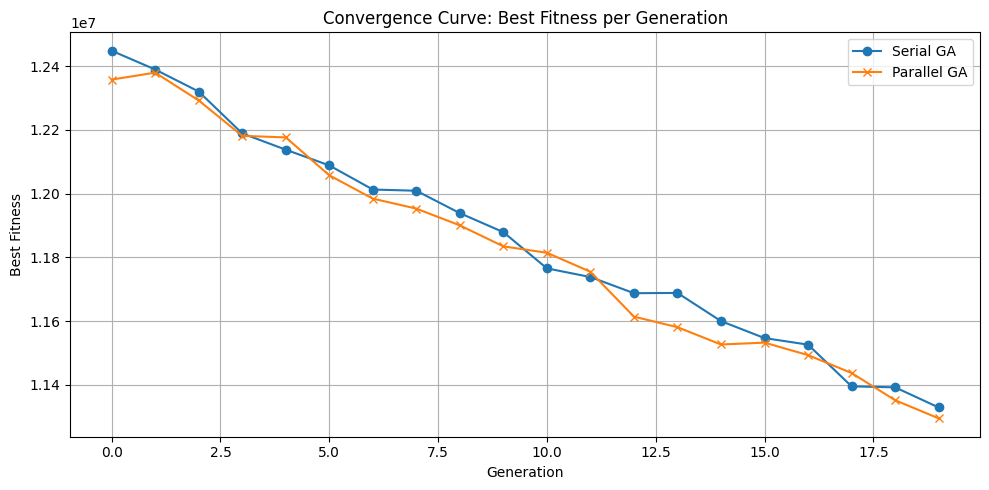

In [ ]:
# Plot fitness convergence
plt.figure(figsize=(10, 5))
plt.plot(serial_curve, label='Serial GA', marker='o')
plt.plot(parallel_curve, label='Parallel GA', marker='x')
plt.title("Convergence Curve: Best Fitness per Generation")
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Mutation Rate vs. Fitness Trade-off Plot


Running Serial GA with Mutation Rate: 0.01
[Serial] Generation 1/20 - Best Fitness: 12383602.98
[Serial] Generation 2/20 - Best Fitness: 12326668.24
[Serial] Generation 3/20 - Best Fitness: 12279322.80
[Serial] Generation 4/20 - Best Fitness: 12163019.04
[Serial] Generation 5/20 - Best Fitness: 12153318.04
[Serial] Generation 6/20 - Best Fitness: 12107214.15
[Serial] Generation 7/20 - Best Fitness: 12039576.73
[Serial] Generation 8/20 - Best Fitness: 11922193.24
[Serial] Generation 9/20 - Best Fitness: 11883717.61
[Serial] Generation 10/20 - Best Fitness: 11801458.81
[Serial] Generation 11/20 - Best Fitness: 11800031.13
[Serial] Generation 12/20 - Best Fitness: 11712609.14
[Serial] Generation 13/20 - Best Fitness: 11590502.29
[Serial] Generation 14/20 - Best Fitness: 11555508.48
[Serial] Generation 15/20 - Best Fitness: 11495598.57
[Serial] Generation 16/20 - Best Fitness: 11463986.01
[Serial] Generation 17/20 - Best Fitness: 11391301.67
[Serial] Generation 18/20 - Best Fitness: 11394

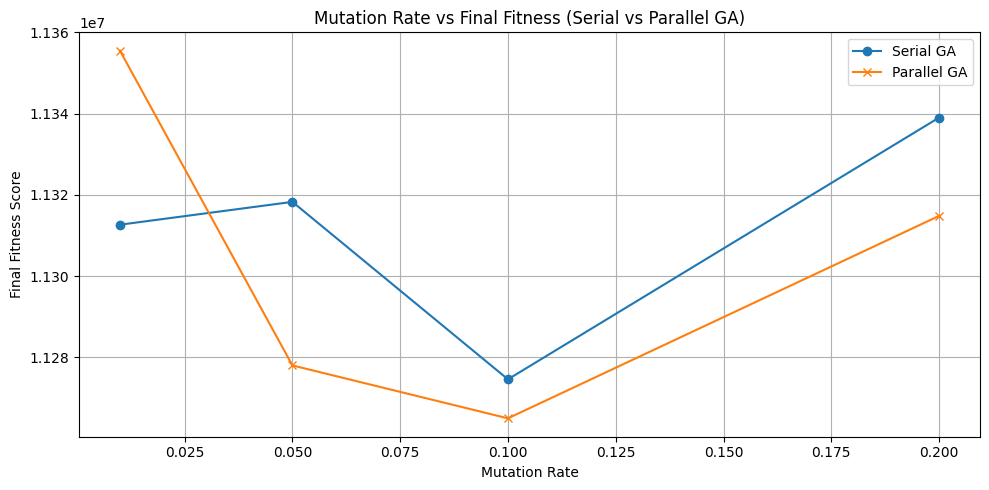

In [ ]:
# Trade-off Analysis: Mutation Rate vs Final Fitness (Both Serial and Parallel GA)

mutation_rates = [0.01, 0.05, 0.1, 0.2]
serial_results = []
parallel_results = []

for rate in mutation_rates:
    print(f"\nRunning Serial GA with Mutation Rate: {rate}")
    _, score_serial, _, _ = run_genetic_algorithm_serial(mutation_rate=rate)
    serial_results.append(score_serial)

    print(f"Running Parallel GA with Mutation Rate: {rate}")
    _, score_parallel, _, _ = run_genetic_algorithm_parallel(mutation_rate=rate)
    parallel_results.append(score_parallel)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(mutation_rates, serial_results, marker='o', label='Serial GA')
plt.plot(mutation_rates, parallel_results, marker='x', label='Parallel GA')
plt.title("Mutation Rate vs Final Fitness (Serial vs Parallel GA)")
plt.xlabel("Mutation Rate")
plt.ylabel("Final Fitness Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Summary

In [ ]:
print("FINAL PERFORMANCE SUMMARY")
print(f"Greedy Baseline Fitness         : {greedy_fitness:.2f}")
print(f"Serial GA Fitness (Final)       : {serial_score:.2f}")
print(f"Parallel GA Fitness (Final)     : {parallel_score:.2f}")
print(f"Serial GA Time Taken            : {serial_time:.2f} seconds")
print(f"Parallel GA Time Taken          : {parallel_time:.2f} seconds")

# Total demand vs supply (helps check if problem is solvable)
print(f"Total Demand (kWh)              : {demand_matrix.sum()}")
print(f"Total Supply (kWh)              : {supply_matrix.sum()}")

# Mutation Rate Comparison Table
print("\nMutation Rate vs Final Fitness Scores:")
print(f"{'Rate':<10} {'Serial GA':<15} {'Parallel GA'}")
for i, rate in enumerate(mutation_rates):
    print(f"{rate:<10.2f} {serial_results[i]:<15.2f} {parallel_results[i]:.2f}")

FINAL PERFORMANCE SUMMARY
Greedy Baseline Fitness         : 648434.32
Serial GA Fitness (Final)       : 11328701.13
Parallel GA Fitness (Final)     : 11294500.22
Serial GA Time Taken            : 32.86 seconds
Parallel GA Time Taken          : 29.97 seconds
Total Demand (kWh)              : 7436.77
Total Supply (kWh)              : 4550.41

Mutation Rate vs Final Fitness Scores:
Rate       Serial GA       Parallel GA
0.01       11312667.29     11355501.15
0.05       11318288.71     11278026.18
0.10       11274604.04     11264997.13
0.20       11339026.57     11314836.66


Bar Plot for Final Fitness Score vs Mutation Rate

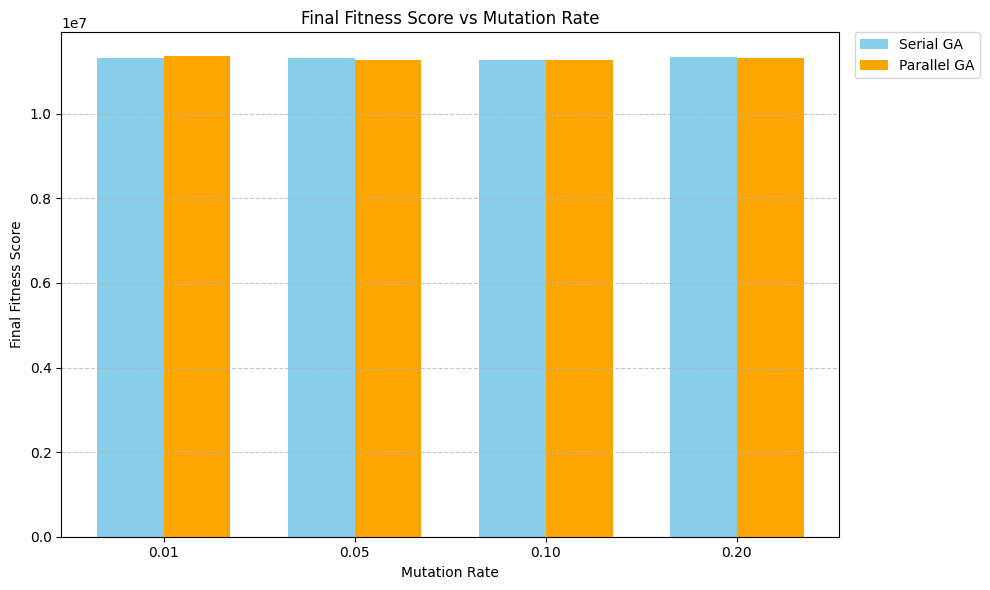

In [ ]:
x = np.arange(len(mutation_rates))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, serial_results, width, label='Serial GA', color='skyblue')
plt.bar(x + width/2, parallel_results, width, label='Parallel GA', color='orange')

plt.title("Final Fitness Score vs Mutation Rate")
plt.xlabel("Mutation Rate")
plt.ylabel("Final Fitness Score")
plt.xticks(x, [f"{r:.2f}" for r in mutation_rates])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), borderaxespad=0)

plt.tight_layout()
plt.show()

Bar Plot for Execution Time Comparison

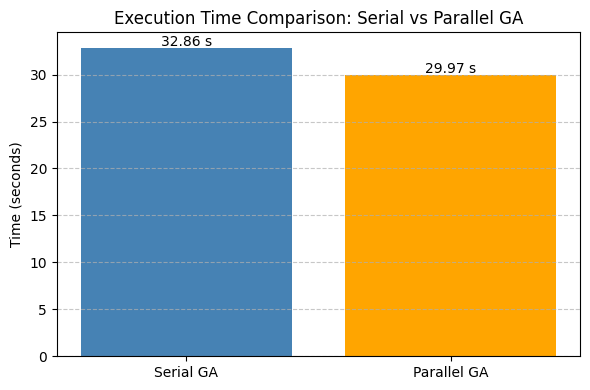

In [ ]:
# Bar Plot: Execution Time Comparison: Serial vs Parallel GA
labels = ['Serial GA', 'Parallel GA']
times = [serial_time, parallel_time]

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, times, color=['steelblue', 'orange'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, f'{yval:.2f} s', ha='center', fontsize=10)

plt.title('Execution Time Comparison: Serial vs Parallel GA')
plt.ylabel('Time (seconds)')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()